# Result analysis

## Imports and data loading

In [9]:
import xarray as xr
import glob
import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

from google.cloud import storage
import gcsfs
import zarr

import xskillscore as xs
import pandas as pd

import os

import re
import skill_metrics as sm

import matplotlib.lines as mlines

In [16]:
results_2022_ws_gcshifted = xr.open_dataset('results_2022_ws_gcshifted.nc')

results = results_2022_ws_gcshifted

results

<xarray.Dataset> Size: 45MB
Dimensions:                           (prediction_timedelta: 16, time: 354,
                                       station: 47)
Coordinates:
  * prediction_timedelta              (prediction_timedelta) timedelta64[ns] 128B ...
  * time                              (time) datetime64[ns] 3kB 2022-01-12 .....
  * station                           (station) <U5 940B '06201' ... '06380'
    lat                               (station) float64 376B ...
    lon                               (station) float64 376B ...
    valid_time                        (time, prediction_timedelta) datetime64[ns] 45kB ...
Data variables: (12/30)
    2m_temperature_hres               (time, prediction_timedelta, station) float32 1MB ...
    mean_sea_level_pressure_hres      (time, prediction_timedelta, station) float32 1MB ...
    10m_v_component_of_wind_hres      (time, prediction_timedelta, station) float32 1MB ...
    10m_u_component_of_wind_hres      (time, prediction_timedelta, station) float32 1MB ...
    total_precipitation_6hr_hres      (time, prediction_timedelta, station) float32 1MB ...
    2m_temperature_synop              (time, prediction_timedelta, station) float64 2MB ...
    ...                                ...
    2m_temperature_meso               (time, prediction_timedelta, station) float32 1MB ...
    mean_sea_level_pressure_meso      (time, prediction_timedelta, station) float32 1MB ...
    10m_v_component_of_wind_meso      (time, prediction_timedelta, station) float32 1MB ...
    10m_u_component_of_wind_meso      (time, prediction_timedelta, station) float32 1MB ...
    10m_wind_speed_meso               (time, prediction_timedelta, station) float32 1MB ...
    total_precipitation_6hr_meso      (time, prediction_timedelta, station) float32 1MB ...

## Taylor diagrams

### Taylor functions

In [11]:
# Function to calculate statistics
def calculate_taylor_statistics(data, reference_data):
    std = data.std(dim=['time', 'station'])
    ccoef = xr.corr(data, reference_data, dim=['time', 'station'])
    crmsd = np.sqrt(((data - reference_data)**2).mean(dim=['time', 'station']))
    return std, ccoef, crmsd

# General function to create subplots for various lead times
def plot_taylor_diagrams_for_lead_times(lead_times, variable, results):
    # Create a grid of subplots (2 rows, 2 columns for 4 lead times)
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
    
    # Flatten the axes array for easier indexing
    axs = axs.flatten()

    # Loop through each lead time and create a Taylor diagram
    for i, lead_time in enumerate(lead_times):
        # Select the desired lead time
        results_selected = results.sel(prediction_timedelta=lead_time)
        
        # Select the desired variable
        results_variable = results_selected[[f'{variable}_hres', f'{variable}_gc', 
                                             f'{variable}_analysis', f'{variable}_meso', f'{variable}_synop']]
        
        # Define suffixes for models and observation
        suffixes = ['hres', 'gc', 'analysis', 'meso', 'synop']

        # Calculate statistics
        std, ccoef, crmsd = {}, {}, {}
        for suffix in suffixes:
            std[suffix], ccoef[suffix], crmsd[suffix] = calculate_taylor_statistics(
                results_variable[f'{variable}_{suffix}'], results_variable[f'{variable}_synop']
            )
                    
        # Reorder suffixes so that observation is first
        suffixes = ['synop', 'hres', 'gc', 'analysis', 'meso']

        # Create arrays for statistics
        std_array = np.array([std[suffix].values for suffix in suffixes])
        ccoef_array = np.array([ccoef[suffix].values for suffix in suffixes])
        crmsd_array = np.array([crmsd[suffix].values for suffix in suffixes])

        # normalize the standard deviations with respect to the observation
        std_array = std_array/std_array[0]

        # Set the current subplot to plot on using plt.sca()
        # plt.sca(axs[i])
        plt.subplot(2, 2, i + 1)  # Use i+1 because subplot indices are 1-based

        # Plot the Taylor diagram in the current subplot
        sm.taylor_diagram(
            std_array, crmsd_array, ccoef_array,
            styleOBS='--', colOBS='b', markerobs='o', titleOBS='SYNOP',
            markerLabel=suffixes, markerLegend='on', markerSize=5,
            colRMS='g', styleRMS=':', titleRMS='on',
            colSTD='grey', styleSTD='-.', titleSTD='on',
            colCOR='grey', styleCOR='--', titleCOR='on'
        )

        # Set the title for each subplot
        plt.title(f'{lead_time} lead time', pad=20)
    
    # Set the overall plot title
    fig.suptitle(f'Taylor Diagrams for {variable.capitalize()}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


### Taylor plots creation

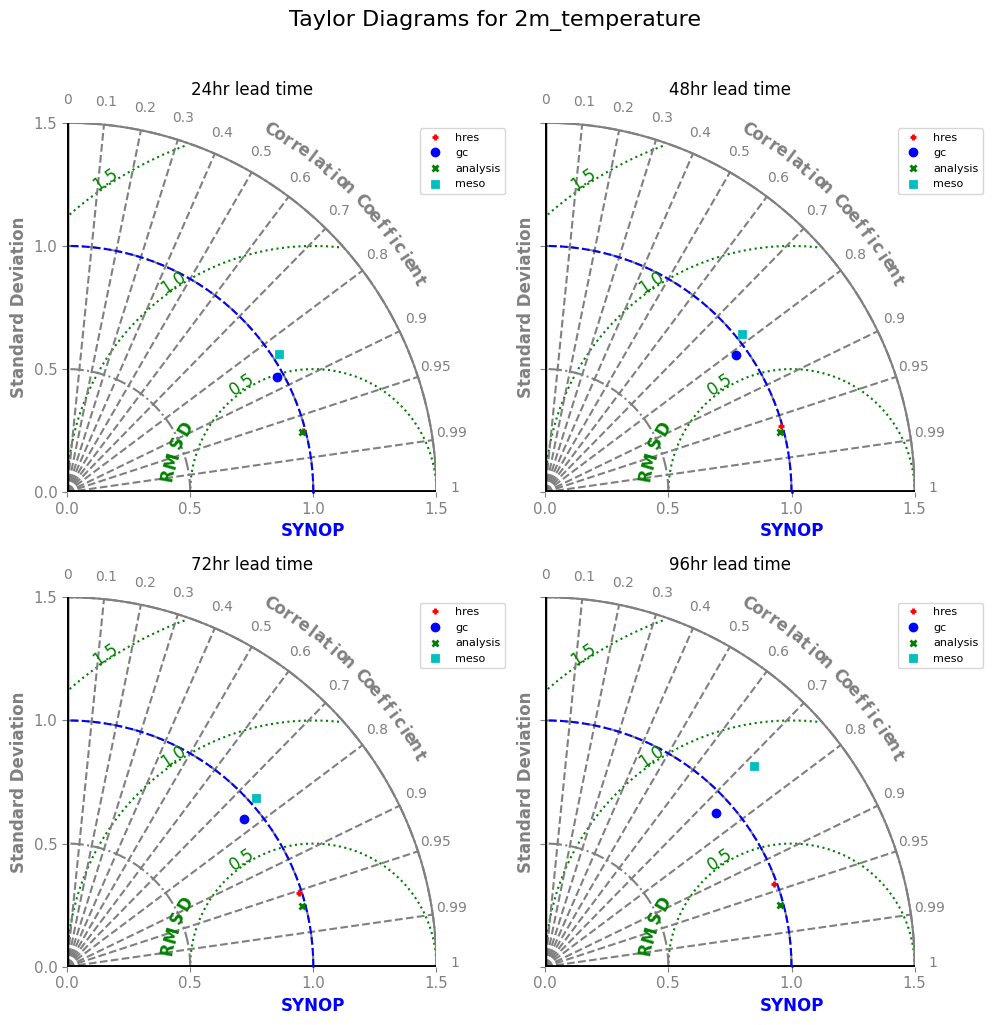

In [12]:
# Example usage for lead times and 2m temperature
lead_times = ['24hr', '48hr', '72hr', '96hr']
plot_taylor_diagrams_for_lead_times(lead_times, '2m_temperature', results)

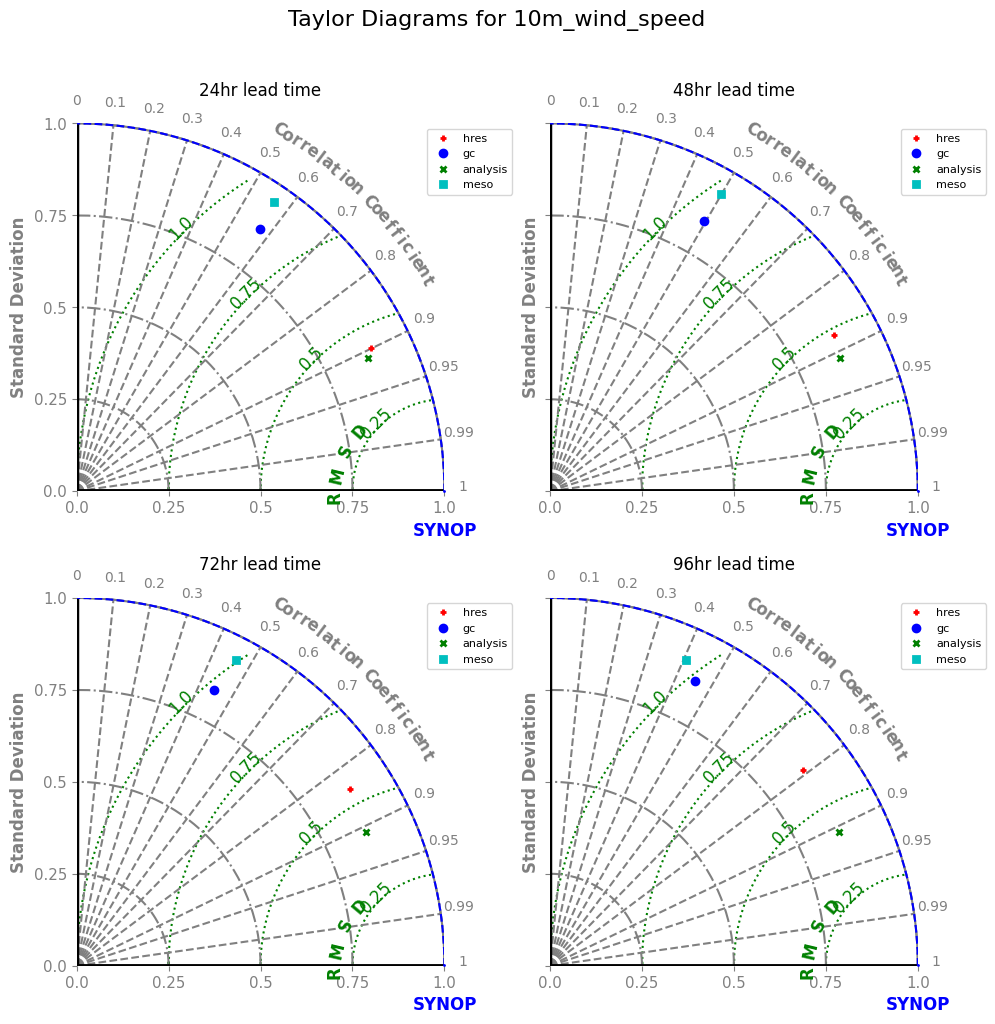

In [14]:
# Example usage for lead times and mean sea level pressure
lead_times = ['24hr', '48hr', '72hr', '96hr']
plot_taylor_diagrams_for_lead_times(lead_times, '10m_wind_speed', results)

/home/koenr/thesis_code/virtualenvs/3_env/lib/python3.10/site-packages/skill_metrics/taylor_diagram.py:360: RuntimeWarning: invalid value encountered in arccos
  rho, theta = STDs, np.arccos(CORs)
/home/koenr/thesis_code/virtualenvs/3_env/lib/python3.10/site-packages/skill_metrics/taylor_diagram.py:360: RuntimeWarning: invalid value encountered in arccos
  rho, theta = STDs, np.arccos(CORs)


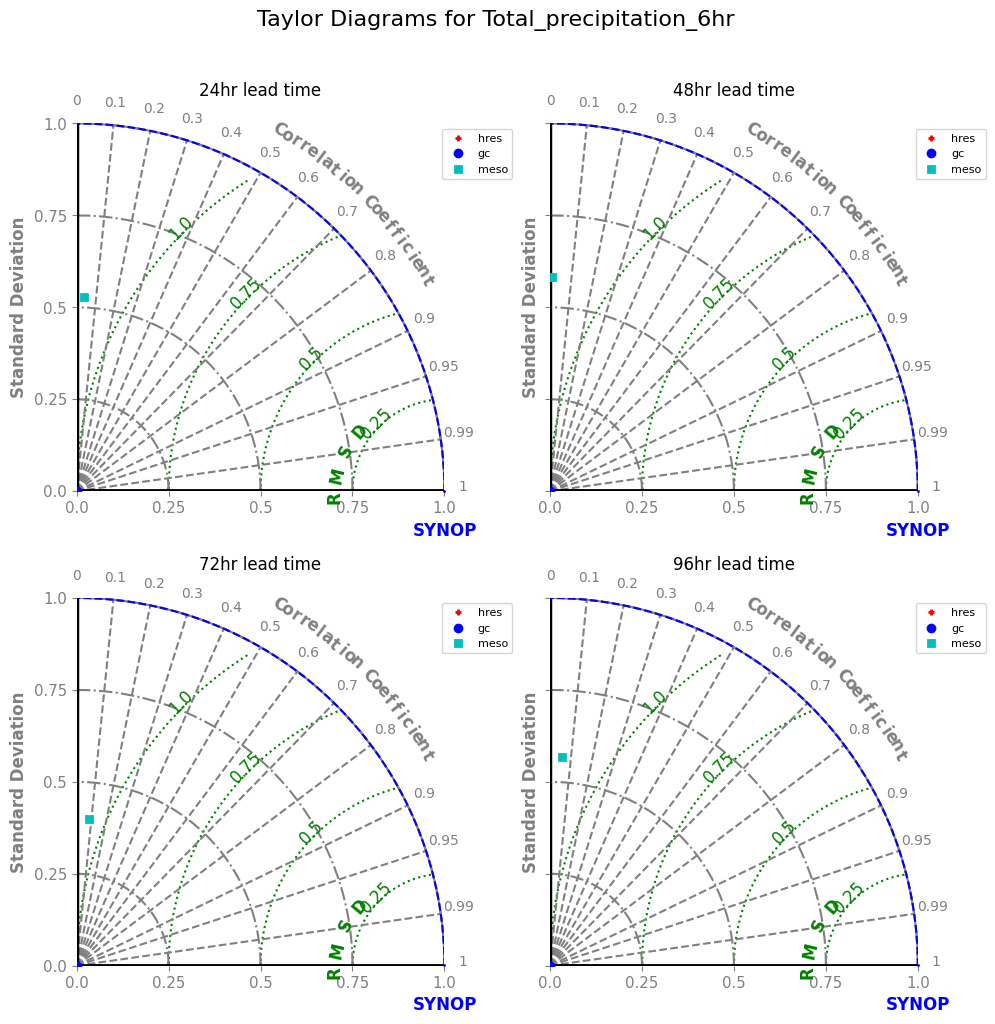

In [15]:
# Example usage for lead times and mean sea level pressure
lead_times = ['24hr', '48hr', '72hr', '96hr']
plot_taylor_diagrams_for_lead_times(lead_times, 'total_precipitation_6hr', results)

/home/koenr/thesis_code/virtualenvs/3_env/lib/python3.10/site-packages/skill_metrics/taylor_diagram.py:360: RuntimeWarning: invalid value encountered in arccos
  rho, theta = STDs, np.arccos(CORs)
/home/koenr/thesis_code/virtualenvs/3_env/lib/python3.10/site-packages/skill_metrics/taylor_diagram.py:360: RuntimeWarning: invalid value encountered in arccos
  rho, theta = STDs, np.arccos(CORs)
/home/koenr/thesis_code/virtualenvs/3_env/lib/python3.10/site-packages/skill_metrics/taylor_diagram.py:360: RuntimeWarning: invalid value encountered in arccos
  rho, theta = STDs, np.arccos(CORs)


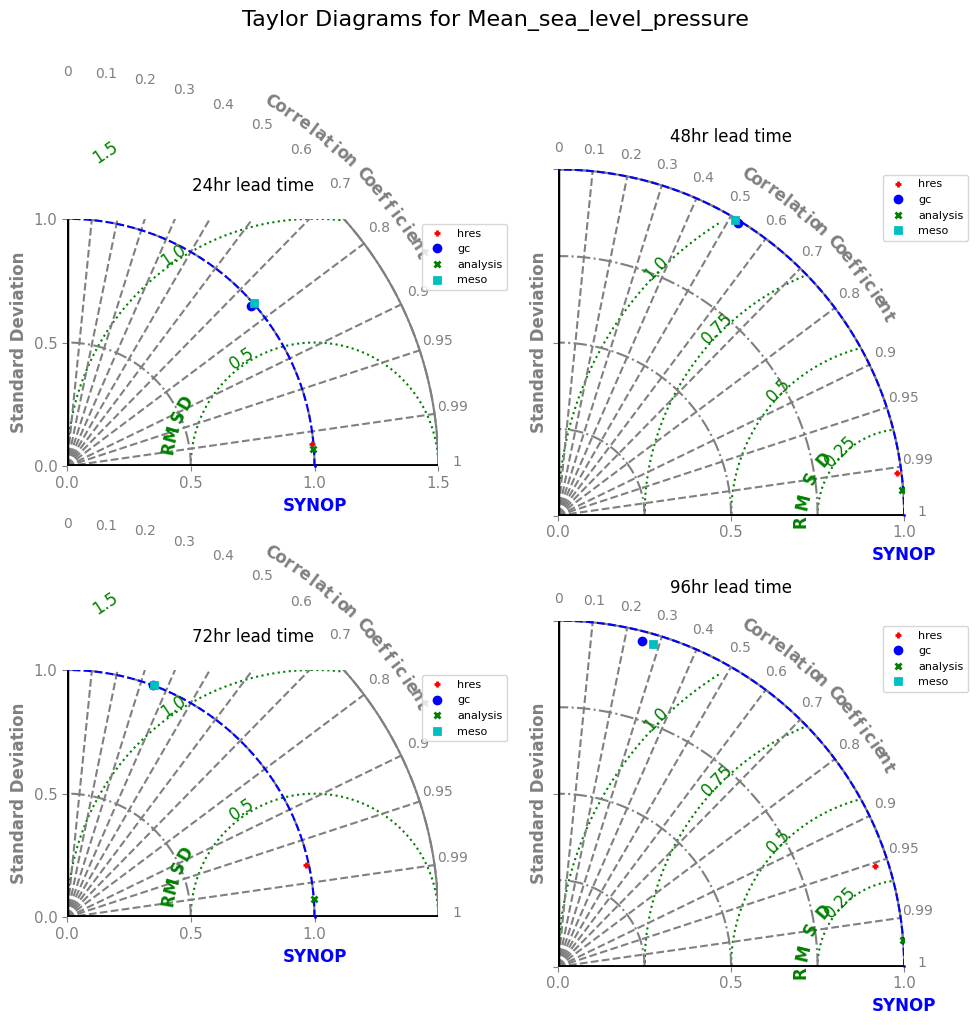

In [13]:
# Example usage for lead times and mean sea level pressure
lead_times = ['24hr', '48hr', '72hr', '96hr']
plot_taylor_diagrams_for_lead_times(lead_times, 'mean_sea_level_pressure', results)